<a href="https://colab.research.google.com/github/jeremyTobias/fashion_mnist/blob/main/jtobias_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Lab 3: Fashion MNIST</b>
### <b>Term:</b> IST718 Spring 2021
### <b>Author:</b> Jeremy Tobias
<sub><sup> Based off https://github.com/2SUBDA/Breakouts/blob/Week7/Week7_MNIST_Classifiers.ipynb, except where noted </sub></sup>

## Setup and data

In [1]:
!pip install -q -U keras-tuner dtreeviz

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 61kB 4.6MB/s 


### Libraries

In [2]:
# BASED ON scikit learn DOCUMENTATION

import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import kerastuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

from sklearn import tree, ensemble, linear_model, metrics, model_selection
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from dtreeviz.trees import dtreeviz

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K

from keras.utils import np_utils

np.random.seed(425) # random seed for consistent results

### The Data

> [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of [Zalando](https://jobs.zalando.com/tech/)'s article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original [MNIST](http://yann.lecun.com/exdb/mnist/) dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

<sub><sup>Source: https://github.com/zalandoresearch/fashion-mnist</sup></sub>

In [3]:
# load fashion-mnist from keras
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) =  fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


The Fashion-MNIST data provides images with pixel values ranging from 0 to 255, and should be normalized, giving the pixels a range between 0 and 1.

In [4]:
# normalize image data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [5]:
# a dataframe to contain the model names, accuracy, execution time to be used for comparison later
fashion_df = pd.DataFrame(columns=['Model', 'Accuracy', 'ExecutionTime'])

# a simple timer to save the time to completion for each model
def timer(startTime):
  comp_time = round((time.time() - startTime), 2)
  
  return comp_time

# append to the dataframe, the lazy way
def appendToDf(modelName, acc, ttc):
  return fashion_df.append({'Model': modelName, 'Accuracy': acc, 'ExecutionTime': ttc}, ignore_index=True)

### Visual sampling

Sample of images after normalizing pixel data

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

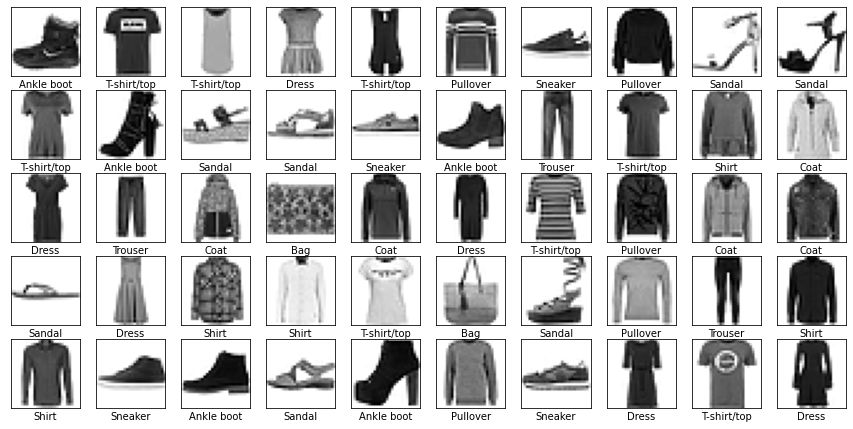

In [7]:
plt.figure(figsize=(15,15))
for i in range(50):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## Base Modeling

Three basic and untuned models, Random Forest, Naive Bayes, and a simple neural network, were used to get a baseline accuracy for the Fashion-MNIST data.

The baseline accuracy will help to determine how effective the tuning performed on the dataset is, both in accuarcy and time performance.

### Random Forest

A random forest is an ensemble of decision trees.  More details can be found [here](https://web.archive.org/web/20160417030218/http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf)

As seen in the output below the untuned random forest classifier performs moderately well with a test accuracy of 87.79% and at a time of just under 3 minutes


In [8]:
%%time

start_time = time.time()

# MODEL BUILD - RANDOM FORESTS
forest = ensemble.RandomForestClassifier(n_estimators=200, max_depth=20)

rf = forest.fit(X_train.reshape(X_train.shape[0], -1), y_train)
rf_comp_time = timer(start_time)

CPU times: user 2min 40s, sys: 287 ms, total: 2min 41s
Wall time: 2min 40s


In [9]:
pred_labels_test = forest.predict(X_test.reshape(X_test.shape[0], -1))

In [10]:
# Basic info about the model
print('\n*************** Tree Summary ***************')
print('No. of classes: ', rf.n_classes_)
print('Classes: ', rf.classes_)
print('No. of features: ', rf.n_features_)
print('No. of Estimators: ', len(rf.estimators_))
print('--------------------------------------------------------')

print('\n*************** Evaluation on Test Data ***************')
score_test = forest.score(X_test.reshape(X_test.shape[0], -1), y_test)
print('Accuracy Score: ', score_test)
# Look at classification report to evaluate the model
print(metrics.classification_report(y_test, pred_labels_test))
print('--------------------------------------------------------')

fashion_df = appendToDf('Random Forest', score_test, rf_comp_time)


*************** Tree Summary ***************
No. of classes:  10
Classes:  [0 1 2 3 4 5 6 7 8 9]
No. of features:  784
No. of Estimators:  200
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8779
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.99      0.96      0.98      1000
           2       0.77      0.80      0.78      1000
           3       0.88      0.91      0.89      1000
           4       0.77      0.82      0.79      1000
           5       0.98      0.95      0.97      1000
           6       0.72      0.59      0.65      1000
           7       0.92      0.95      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg  

### Bayes

The naive Bayes model finishes extremely fast at >1 second. However, the accuracy is roughly the same as it would be if we had used a coin to classify each image at a dissapointing 58.56%. Additional tuning may be effective.

In [11]:
%%time

start_time = time.time()

# MODEL

# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(X_train.reshape(X_train.shape[0], -1), y_train)
nb_comp_time = timer(start_time)

CPU times: user 306 ms, sys: 55.9 ms, total: 362 ms
Wall time: 360 ms


In [12]:
# MODEL

# Make predictions
preds = gnb.predict(X_test.reshape(X_test.shape[0], -1))
# print(preds)

In [13]:
# MODEL

# Evaluate accuracy
nb_acc = accuracy_score(y_test, preds)

fashion_df = appendToDf('Naive Bayes', nb_acc, nb_comp_time)

print(nb_acc)

0.5856


In [14]:
# INTERPRET

expected = y_test
predicted = preds
print(sklearn.metrics.confusion_matrix(expected, predicted))

[[586  64  29 162 110   0  20   0  29   0]
 [  1 939  14  36   7   0   1   0   2   0]
 [  7  14 324  65 545   0  23   0  22   0]
 [  9 387   6 545  43   0   4   0   6   0]
 [  0  34  44 131 779   0   4   0   8   0]
 [  0   0   1   1   0 278   3 660   5  52]
 [117  34 112 200 435   0  40   0  62   0]
 [  0   0   0   0   0   3   0 988   0   9]
 [  0   2  19  85 149   3  27   4 710   1]
 [  0   0   1   1   0  16   3 304   8 667]]


### Neural Network

A basic neural network using TensorFlow Keras based on https://www.tensorflow.org/tutorials/keras/classification, with only one hidden layer containing 128 neurons. In the outputs shown below, we see that we get a slight increase in test accuracy to 88.98%. However, the increase comes at a completion time cost just under 5 minutes. About 2 minutes slower than the Random Forest, with an accuracy increase just over 1%.

In [15]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [16]:
nn_model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
%%time

start_time = time.time()

nn_history = nn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), workers=5, use_multiprocessing=True)
nn_comp_time = timer(start_time)

Epoch 1/50
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4914 - accuracy: 0.8283 - val_loss: 0.4359 - val_accuracy: 0.8416
Epoch 2/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3662 - accuracy: 0.8685 - val_loss: 0.3823 - val_accuracy: 0.8643
Epoch 3/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3292 - accuracy: 0.8810 - val_loss: 0.3666 - val_accuracy: 0.8667
Epoch 4/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3057 - accuracy: 0.8888 - val_loss: 0.3525 - val_accuracy: 0.8743
Epoch 5/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2874 - accuracy: 0.8942 - val_loss: 0.3522 - val_accuracy: 0.8729
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2738 - accuracy: 0.8989 - val_loss: 0.3484 - val_accuracy: 0.8744
Epoch 7/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2620 - accuracy: 0.9025 - val_loss: 0.3494 - val_accuracy:

Observing the charts below, we see that there is some overfitting happening within the neural network. While the training accuracy and loss rise and drop, respectively, the test loss rises by quite a lot and with little gain in accuracy. Additional tuning of the network might provide better results.

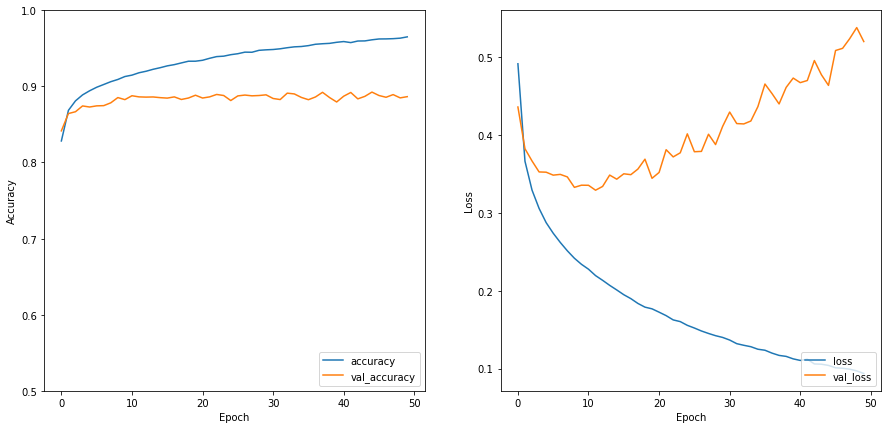

In [18]:
fig = plt.subplots(figsize=(15, 7))

plt.subplot(121)
plt.plot(nn_history.history['accuracy'], label='accuracy')
plt.plot(nn_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.subplot(122)
plt.plot(nn_history.history['loss'], label='loss')
plt.plot(nn_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

In [19]:
test_loss, test_acc = nn_model.evaluate(X_test,  y_test, verbose=2)

fashion_df = appendToDf('Neural Network', test_acc, nn_comp_time)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.5199 - accuracy: 0.8865

Test accuracy: 0.8865000009536743


## Tuning and Advanced Modeling

Several attempts at tuning and using more advanced modeling techniques were performed to see if better models could be constrcuted. Tuning was performed on both random forest and the neural network models. Due to the poor accuracy performance of naive Bayes, it was abandoned in favor of other models. Namely, gradient boosted trees and convolutional neural networks.

Gradient boosted trees were used in a more basic format, with no tuning, while the convolutional neural network tuning was attempted using a couple different methods. Specifically, data augmentation and hyperparameter tuning.

### Tuning Functions

In [20]:
# https://www.tensorflow.org/tutorials/keras/keras_tuner
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(layers.Dense(units=hp_units, 
                         kernel_regularizer=regularizers.l2(0.0001), # from https://www.tensorflow.org/tutorials/keras/overfit_and_underfit 
                         activation='relu'))
  model.add(layers.Dense(10, kernel_initializer='normal', activation='softmax'))
  model.add(layers.Dropout(0.15))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model


# https://keras-team.github.io/keras-tuner/documentation/tuners/#sklearn-class
def skl_model_builder(hp):
  model = ensemble.RandomForestClassifier(
      n_estimators = hp.Int('n_estimators', 10, 200, step=10),
      max_depth = hp.Int('max_depth', 3, 20))

  return model


# https://medium.com/analytics-vidhya/convolutional-neuronal-network-with-keras-tuner-on-cifar-10-b4271ca4643d
def cnn_model_builder(hp):
  model = models.Sequential()
  model.add(layers.Conv2D(hp.Int('input_units',
                                 min_value=32,
                                 max_value=256,
                                 step=32),
                          (3, 3), activation='relu',
                          kernel_regularizer=regularizers.l2(0.0001),
                          input_shape=X_train_cnn.shape[1:]))
  
  model.add(layers.MaxPooling2D((2, 2)))

  # Tune some hidden convolutional layers
  # Choose an optimal number of inputes between 32 and 256
  for i in range(hp.Int('n_layers', 1, 4)):
    model.add(layers.Conv2D(hp.Int(f'conv_{i}_units',
                                 min_value=32,
                                 max_value=256,
                                 step=32),
                            (3, 3), activation='relu',
                            kernel_regularizer=regularizers.l2(0.0001)))
    model.add(layers.Dropout(0.25))
    model.add(layers.BatchNormalization())
  
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  
  # Tune some fully connected layers
  # Choose an optimal number of nodes from the list 128, 256, 512, or 1024
  for i in range(hp.Int('n_connections', 1, 4)):
    model.add(layers.Dense(hp.Choice(f'n_nodes', values=[128,256,512,1024]), 
                           kernel_regularizer=regularizers.l2(0.0001),
                           activation='relu'))
    model.add(layers.Dropout(0.25))
  
  # model.add(layers.Dropout(0.3))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

### Tuned Random Forest

The tuned random forest takes advantage of Keras Tuner's [SKL tuning](https://keras-team.github.io/keras-tuner/documentation/tuners/#sklearn-class) library to search for an optimal number of estimators and depth.

However, even with a tuned random forest, the test accuracy is roughly the same with a final test accuracy of 87.61%, only slightly below the basic random forest. Additionally, the time to execution was increased greatly due to the search for an optimal model. At nearly an hour searching for an optimal model, no significant gains were made. Additional tuning may result in better accuracy, however.

In [21]:
skl_tuner = kt.tuners.Sklearn(
    oracle=kt.oracles.BayesianOptimization(
        objective=kt.Objective('score', 'max'),
        max_trials=10),
    hypermodel=skl_model_builder,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    cv=model_selection.StratifiedKFold(5),
    directory='.',
    project_name='skl_tune')

In [22]:
%%time

start_time = time.time()

skl_tuner.search(X_train.reshape(X_train.shape[0], -1), y_train)

Trial 10 Complete [00h 11m 00s]
score: 0.8818333333333334

Best score So Far: 0.8833499999999999
Total elapsed time: 00h 55m 24s
INFO:tensorflow:Oracle triggered exit
CPU times: user 55min 40s, sys: 0 ns, total: 55min 40s
Wall time: 55min 24s


In [23]:
trf_best_model = skl_tuner.get_best_models(num_models=1)[0]

In [24]:
%%time

trf_history = trf_best_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

trf_comp_time = timer(start_time)

CPU times: user 2min 41s, sys: 0 ns, total: 2min 41s
Wall time: 2min 41s


In [25]:
trf_pred_labels_test = trf_history.predict(X_test.reshape(X_test.shape[0], -1))

In [26]:
# Basic info about the model
print('\n*************** Tree Summary ***************')
print('No. of classes: ', trf_history.n_classes_)
print('Classes: ', trf_history.classes_)
print('No. of features: ', trf_history.n_features_)
print('No. of Estimators: ', len(trf_history.estimators_))
print('--------------------------------------------------------')

print('\n*************** Evaluation on Test Data ***************')
score_test = trf_best_model.score(X_test.reshape(X_test.shape[0], -1), y_test)
print('Accuracy Score: ', score_test)
# Look at classification report to evaluate the model
print(metrics.classification_report(y_test, trf_pred_labels_test))
print('--------------------------------------------------------')

fashion_df = appendToDf('Tuned Random Forest', score_test, trf_comp_time)


*************** Tree Summary ***************
No. of classes:  10
Classes:  [0 1 2 3 4 5 6 7 8 9]
No. of features:  784
No. of Estimators:  200
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8759
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.77      0.80      0.78      1000
           3       0.87      0.91      0.89      1000
           4       0.76      0.82      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.72      0.59      0.65      1000
           7       0.92      0.95      0.93      1000
           8       0.96      0.97      0.97      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg  

### Boosted Trees

The gradient boosted tree took nearly 15 minutes to complete and resulted in a lower test accuracy of 86.95%. This could be due to poor tuning of the model.

In [27]:
tree_boost = ensemble.GradientBoostingClassifier(loss='deviance',
                                                 criterion='mse',
                                                 learning_rate=1.0,
                                                 subsample=1.0,
                                                 random_state=425,
                                                 max_features='sqrt',
                                                 min_samples_leaf=1000,
                                                 max_depth=100,
                                                 n_estimators=200)

In [28]:
%%time

start_time = time.time()

gbf = tree_boost.fit(X_train.reshape(X_train.shape[0], -1), y_train)

gbf_comp_time = timer(start_time)

CPU times: user 14min 20s, sys: 0 ns, total: 14min 20s
Wall time: 14min 16s


In [29]:
pred_labels_test = tree_boost.predict(X_test.reshape(X_test.shape[0], -1))

In [30]:
# Basic info about the model
print('\n*************** Tree Summary ***************')
print('No. of classes: ', gbf.n_classes_)
print('Classes: ', gbf.classes_)
print('No. of features: ', gbf.n_features_)
print('No. of Estimators: ', len(gbf.estimators_))
print('--------------------------------------------------------')

print('\n*************** Evaluation on Test Data ***************')
score_test = tree_boost.score(X_test.reshape(X_test.shape[0], (X_test.shape[1] * X_test.shape[2])), y_test)
print('Accuracy Score: ', score_test)
# Look at classification report to evaluate the model
print(metrics.classification_report(y_test, pred_labels_test))
print('--------------------------------------------------------')

fashion_df = appendToDf('Boosted Trees', score_test, gbf_comp_time)


*************** Tree Summary ***************
No. of classes:  10
Classes:  [0 1 2 3 4 5 6 7 8 9]
No. of features:  784
No. of Estimators:  200
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8695
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.98      0.96      0.97      1000
           2       0.76      0.80      0.78      1000
           3       0.87      0.88      0.88      1000
           4       0.78      0.77      0.78      1000
           5       0.96      0.95      0.96      1000
           6       0.68      0.64      0.66      1000
           7       0.94      0.95      0.94      1000
           8       0.96      0.96      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg  

### Tuned Neural Network

Similar to the random forest, we attempt to tune the neural network using [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

Additionally an early stop was declared, so that the training can complete if epochs were determined to no longer be making any progress.

A dropout rate was also declared in the model building function to try to aid with the overfitting problem experienced in the basic neural network classification task.

Upon completion of the search for best hyperparameters the data was fit to the best model resulting from the search, and fit one last time using the best epoch from the hyper tuning.

In [31]:
# create a tuner for our neural network
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     hyperband_iterations=2,
                     directory='.',
                     project_name='nn_tune')

In [32]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4) # stop early if the validation loss value does not go down after consecutive 4 epochs

In [33]:
%%time

start_time = time.time()

# search for the optimal model
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early], workers=5, use_multiprocessing=True)

# get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 56 Complete [00h 00m 34s]
val_accuracy: 0.8550833463668823

Best val_accuracy So Far: 0.8573333621025085
Total elapsed time: 00h 19m 57s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.0001.

CPU times: user 1h 17min 29s, sys: 26min 2s, total: 1h 43min 31s
Wall time: 19min 57s


In [34]:
%%time

# build the model with the optimal hyperparameters and train it on the data for 50 epochs
tnn_model = tuner.hypermodel.build(best_hps)
tnn_history = tnn_model.fit(X_train, 
                            y_train, 
                            batch_size=128, 
                            epochs=50, 
                            validation_data=(X_test, y_test), 
                            workers=5,
                            use_multiprocessing=True)

val_acc_per_epoch = tnn_history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
469/469 [==============================] - 4s 7ms/step - loss: 1.8845 - accuracy: 0.6158 - val_loss: 1.7747 - val_accuracy: 0.7688
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 1.7572 - accuracy: 0.6831 - val_loss: 1.7382 - val_accuracy: 0.7902
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 1.7284 - accuracy: 0.7038 - val_loss: 1.7080 - val_accuracy: 0.8164
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 1.7008 - accuracy: 0.7243 - val_loss: 1.6915 - val_accuracy: 0.8326
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 1.6875 - accuracy: 0.7305 - val_loss: 1.6815 - val_accuracy: 0.8380
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 1.6787 - accuracy: 0.7353 - val_loss: 1.6766 - val_accuracy: 0.8407
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 1.6712 - accuracy: 0.7391 - val_loss: 1.6681 - val_accuracy: 0.8469
Epoch 

Viewing the chart below, we notice that the val_accuracy (test data) is quite a bit higher than the training accuracy. This is somewhat expected due to the dropout rate not being included during validation [Source: Keras FAQ](eras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss).

However, viewing the loss graphic we notice that loss of the tuned neural network is significantly better than that of the basic neural network.

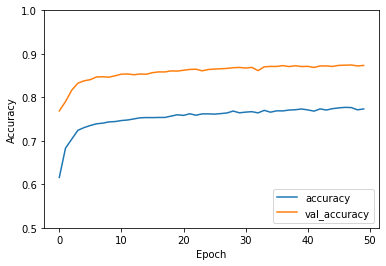

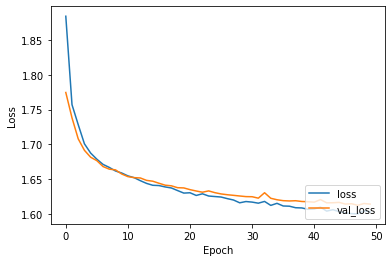

In [35]:
plt.plot(tnn_history.history['accuracy'], label='accuracy')
plt.plot(tnn_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.show()

plt.plot(tnn_history.history['loss'], label='loss')
plt.plot(tnn_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

In [36]:
%%time

hypermodel = tuner.hypermodel.build(best_hps)

# retrain the model
nn_hp = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2, workers=5, use_multiprocessing=True)

tnn_comp_time = timer(start_time)

Epoch 1/48
1500/1500 [==============================] - 7s 4ms/step - loss: 1.8175 - accuracy: 0.6489 - val_loss: 1.7216 - val_accuracy: 0.8137
Epoch 2/48
1500/1500 [==============================] - 6s 4ms/step - loss: 1.7115 - accuracy: 0.7187 - val_loss: 1.6871 - val_accuracy: 0.8360
Epoch 3/48
1500/1500 [==============================] - 6s 4ms/step - loss: 1.6870 - accuracy: 0.7314 - val_loss: 1.6747 - val_accuracy: 0.8427
Epoch 4/48
1500/1500 [==============================] - 6s 4ms/step - loss: 1.6786 - accuracy: 0.7330 - val_loss: 1.6645 - val_accuracy: 0.8474
Epoch 5/48
1500/1500 [==============================] - 6s 4ms/step - loss: 1.6718 - accuracy: 0.7345 - val_loss: 1.6576 - val_accuracy: 0.8527
Epoch 6/48
1500/1500 [==============================] - 6s 4ms/step - loss: 1.6628 - accuracy: 0.7397 - val_loss: 1.6508 - val_accuracy: 0.8567
Epoch 7/48
1500/1500 [==============================] - 6s 4ms/step - loss: 1.6560 - accuracy: 0.7444 - val_loss: 1.6494 - val_accuracy:

While training using the best epoch approach with the hyperparameters doesn't yield much better accuracy, we do notice that the loss does improve.

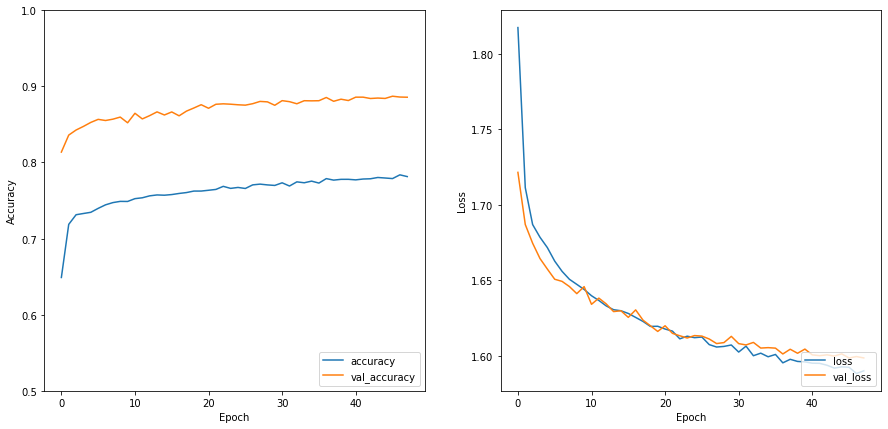

In [37]:
fig = plt.subplots(figsize=(15, 7))

plt.subplot(121)
plt.plot(nn_hp.history['accuracy'], label='accuracy')
plt.plot(nn_hp.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.subplot(122)
plt.plot(nn_hp.history['loss'], label='loss')
plt.plot(nn_hp.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

In [38]:
eval_loss, eval_acc = hypermodel.evaluate(X_test, y_test, verbose=2)
fashion_df = appendToDf('Tuned Neural Network', eval_acc, tnn_comp_time)
print("test loss: {} ; test accuracy: {}".format(eval_loss, eval_acc))

313/313 - 1s - loss: 1.6064 - accuracy: 0.8787
test loss: 1.6063628196716309 ; test accuracy: 0.8787000179290771


### Image augmentation

Image augmentation was performed using [Keras' ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) library. This was done to give a more diverse representation of the dataset with the hope of improving overall accuracy.

A sample of the original images and the augmented images can be seen below.

BEFORE:



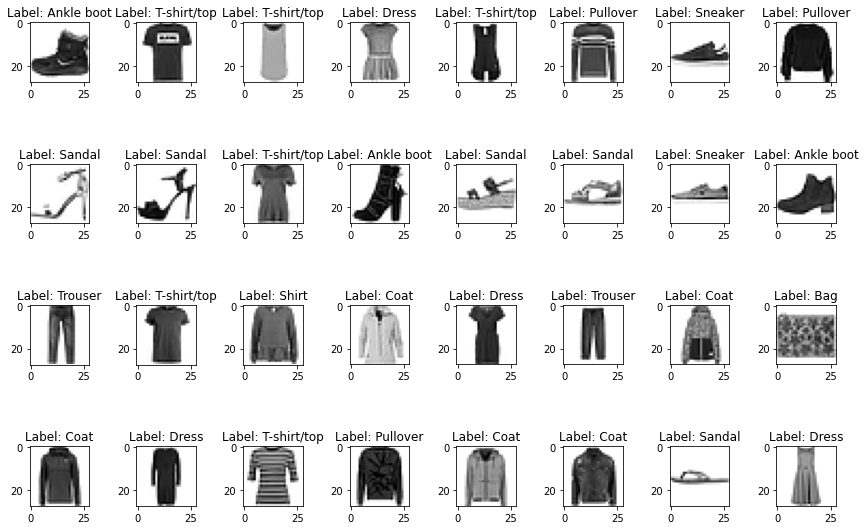

AFTER:



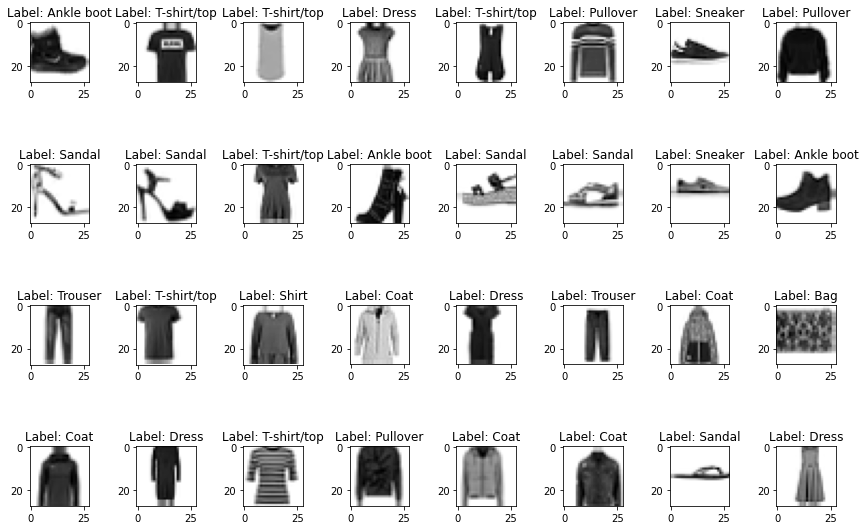

In [39]:
# reshape the data to be used with Conv2D nicely
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# ensure the labels are categorical data
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

# https://medium.com/the-data-science-publication/how-to-augment-the-mnist-dataset-using-tensorflow-4fbf113e99a0
# specify the arguments
rotation_range_val = 0
width_shift_val = 0.1
height_shift_val = 0.1
# shear_range_val=45
# zoom_range_val=[0.5,1.5]

# import relevant library
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create the class object
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=rotation_range_val,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=width_shift_val,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=height_shift_val,  # randomly shift images vertically (fraction of total height)
    # shear_range=shear_range_val, # randomly zoom images
    # zoom_range=zoom_range_val, # randomly shear images
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    validation_split=0.2
    )

# fit the generator
datagen.fit(X_train_cnn)

# define number of rows & columns
num_row = 4
num_col = 8
num = num_row*num_col

# plot before
print('BEFORE:\n')
# plot images
fig1, axes1 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
  ax = axes1[i//num_col, i%num_col]
  ax.imshow(X_train[i], cmap='gray_r')
  ax.set_title('Label: {}'.format(class_names[y_train[i]]))
plt.tight_layout()
plt.show()

# plot after
print('AFTER:\n')
fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for X, Y in datagen.flow(X_train_cnn, y_train.reshape(y_train.shape[0], 1),batch_size=num,shuffle=False):
     for i in range(0, num):
          ax = axes2[i//num_col, i%num_col]
          ax.imshow(X[i].reshape(28,28), cmap='gray_r')
          ax.set_title('Label: {}'.format(class_names[int(Y[i])]))
     break
plt.tight_layout()
plt.show()

### Convolutional Neural Network

Using the augmented image data, we perform a similar search that was done with the tuned neural network for the best hypermodel. Due to the amount of time to search for an optimal model, additional measures were taken to try and reduce the time to search while retaining the highest accuracy possible.

To try to account for overfitting, additional dropouts were inserted in the fully connected layers. Addiontionally, [kernel regularizers](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) were included in the initial layer as well as the fully connected layers.

In [40]:
import math

training_size = len(X_train_cnn)
test_size = len(X_test_cnn)

epochs = 25
batch_size = int(math.sqrt(training_size)) # https://docs.paperspace.com/machine-learning/wiki/epoch

def calculate_spe(y): # determine the correct steps per epoch we should be using
  return int(math.ceil((1. * y) / batch_size))

steps_per_epoch = calculate_spe(training_size)
validation_steps = calculate_spe(test_size)

print(steps_per_epoch)
print(validation_steps)

246
41


In [41]:
# create a tuner for our convolutional neural network
cnn_tuner = kt.RandomSearch(cnn_model_builder,
                            objective='val_accuracy',
                            max_trials=4,
                            executions_per_trial=2,
                            directory='.',
                            project_name='tuned_cnn')

In [42]:
%%time

start_time = time.time()

# search for the best model using the augmented data and features declared in the cnn_model_builder function
cnn_tuner.search(datagen.flow(X_train_cnn, y_train_cnn, batch_size=batch_size, subset='training', shuffle=True),
                 validation_data=datagen.flow(X_train_cnn, y_train_cnn, batch_size=(int(math.ceil(batch_size / 4))), subset='validation', shuffle=True),
                 epochs=epochs,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps,
                 callbacks=[stop_early],
                 workers=5,
                 use_multiprocessing=True)

Trial 4 Complete [00h 46m 49s]
val_accuracy: 0.9082367122173309

Best val_accuracy So Far: 0.9082367122173309
Total elapsed time: 02h 16m 37s
INFO:tensorflow:Oracle triggered exit
CPU times: user 1d 16h 49min 55s, sys: 6h 12min 17s, total: 1d 23h 2min 12s
Wall time: 2h 16min 37s


In [43]:
cnn_model = cnn_tuner.get_best_models(num_models=1)[0]
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 224)       2240      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 160)       322720    
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 160)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 160)       640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 224)         322784    
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 224)         0

In [44]:
%%time

# reset the stop early callback so we can get a larger number of epochs to determine loss trend
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# fit the best model using the augmented training data and validate against the original test set
cnn_history = cnn_model.fit(datagen.flow(X_train_cnn, y_train_cnn, batch_size=batch_size, shuffle=True), 
                            epochs=50,
                            validation_data=(X_test_cnn, y_test_cnn), 
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            callbacks=[stop_early],
                            workers=5,
                            use_multiprocessing=True)

cnn_comp_time = timer(start_time)

Epoch 1/50
246/246 [==============================] - 83s 324ms/step - loss: 0.3529 - accuracy: 0.9006 - val_loss: 0.3660 - val_accuracy: 0.8969
Epoch 2/50
246/246 [==============================] - 83s 334ms/step - loss: 0.3522 - accuracy: 0.9003 - val_loss: 0.3641 - val_accuracy: 0.8911
Epoch 3/50
246/246 [==============================] - 85s 341ms/step - loss: 0.3445 - accuracy: 0.9045 - val_loss: 0.3593 - val_accuracy: 0.9024
Epoch 4/50
246/246 [==============================] - 87s 348ms/step - loss: 0.3463 - accuracy: 0.9032 - val_loss: 0.3739 - val_accuracy: 0.8934
Epoch 5/50
246/246 [==============================] - 88s 354ms/step - loss: 0.3464 - accuracy: 0.9045 - val_loss: 0.3222 - val_accuracy: 0.9104
Epoch 6/50
246/246 [==============================] - 90s 360ms/step - loss: 0.3409 - accuracy: 0.9069 - val_loss: 0.3201 - val_accuracy: 0.9139
Epoch 7/50
246/246 [==============================] - 89s 356ms/step - loss: 0.3396 - accuracy: 0.9065 - val_loss: 0.3459 - val_ac

Observing the charts below, we see a a gradual rise in accuracy over the training epochs, but a generally straight line for test accuracies, although increasing slightly.

The training stopped after 24 of the 50 epochs, suggesting that no more progress was being made based on the early stopping settings so the loss does not show a lot of information. It's possible that it would have ended sooner had the early stop setting been lower. The overall loss for the training shows a downward trend, but the test loss goes from a downward trend to an upward one around epoch 15. This suggests that we still might have an overfitting problem, despite the mitigation efforts of inserting dropout and regularizers in to the model.

Additional tuning can likely improve time to complete, accuracy, and loss.

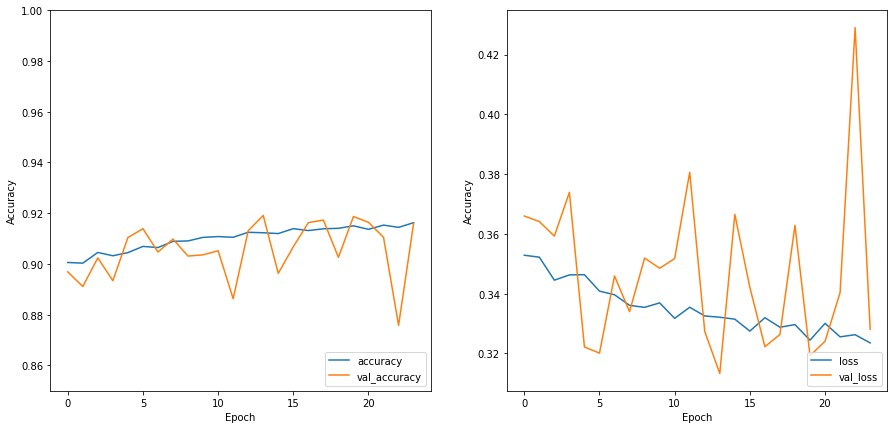

In [45]:
fig = plt.subplots(figsize=(15, 7))

plt.subplot(121)
plt.plot(cnn_history.history['accuracy'], label='accuracy')
plt.plot(cnn_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.85, 1])
plt.legend(loc='lower right')

plt.subplot(122)
plt.plot(cnn_history.history['loss'], label='loss')
plt.plot(cnn_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [46]:
test_loss, test_acc = cnn_model.evaluate(X_test_cnn,  y_test_cnn, verbose=2)

fashion_df = appendToDf('CNN', test_acc, cnn_comp_time)

print(test_acc)

313/313 - 5s - loss: 0.3281 - accuracy: 0.9160
0.9160000085830688


## Comparisons and Conclusions

While it took nearly 3 hours to complete all of the tasks, the convolutional neural network (CNN) was able to best classify the fashion MNIST data with an 91.60% accuracy on the test data. Around 3% better than the next best accuracy. If time is not a concern to us and accuracy is of a high concern, CNN is clearly the best modeling option for this task, despite some of the overfitting. Addtional tuning can likely decrease the overfitting problem, and potentially increase accuracy even more.

The fastest overall time was the naive bayes classifier, but it also achieved the overall lowest accuracy at 58.56%. Significantly lower than any other classifer.

Although the basic neural network was able to get a higher accuracy, it was significantly overfit. Whereas, the random forest and tunned neural network fit better to the data. That being said, despite fitting relatively well, none of the other models were particularly accuracte compared to CNN. Consider the table and graph below for more information.

In [47]:
fashion_df.sort_values(['Accuracy', 'ExecutionTime'], ascending=False)

,Model,Accuracy,ExecutionTime
6,CNN,0.9160,10332.49
2,Neural Network,0.8865,288.45
5,Tuned Neural Network,0.8787,1653.31
0,Random Forest,0.8779,160.35
3,Tuned Random Forest,0.8759,3486.18
4,Boosted Trees,0.8695,856.95
1,Naive Bayes,0.5856,0.36


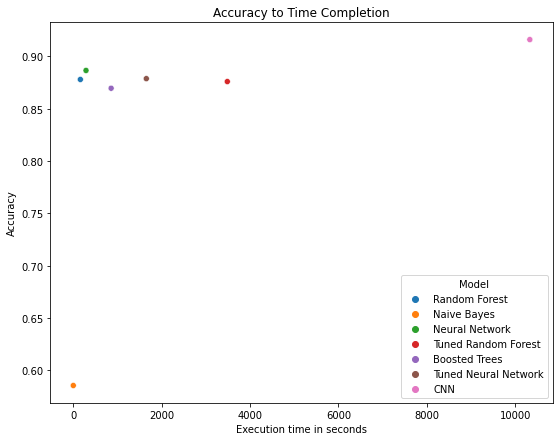

In [48]:
fig = plt.subplots(figsize=(9, 7))
sns.scatterplot(x='ExecutionTime', y='Accuracy', hue='Model', data=fashion_df)
plt.xlabel('Execution time in seconds')

plt.title('Accuracy to Time Completion')
plt.show()